In [1]:
import matplotlib.pyplot as plt
import torch
from spectpsftoolbox.operator2d import GaussianOperator, Kernel2DOperator
from spectpsftoolbox.kernel2d import NGonKernel2D
from spectpsftoolbox.utils import get_kernel_meshgrid
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Operator Intro

Operators in `spectpsftoolbox` are used to convolve kernels with various inputs. Let's start by recreating the ngon kernel we made in tutorial 2

In [2]:
collimator_length = 2.405 
collimator_width = 0.254 #flat side to flat side
sigma_fn = lambda a, bs: (bs[0]+a) / bs[0] 
sigma_params = torch.tensor([collimator_length], requires_grad=True, dtype=torch.float32, device=device)
# Set amplitude to 1
amplitude_fn = lambda a, bs: torch.ones_like(a)
amplitude_params = torch.tensor([1.], requires_grad=True, dtype=torch.float32, device=device)

ngon_kernel = NGonKernel2D(
    N_sides = 6, # sides of polygon
    Nx = 255, # resolution to make polygon before grid sampling
    collimator_width=collimator_width, # width of polygon
    amplitude_fn=amplitude_fn,
    sigma_fn=sigma_fn,
    amplitude_params=amplitude_params,
    sigma_params=sigma_params,
    rot=90
)

Note that this operator takes in `xv`, `yv`, and `a` and returns the correpsonding kernel:

In [3]:
Nx0 = 255
dx0 = 0.048
x = y = torch.arange(-(Nx0-1)/2, (Nx0+1)/2, 1).to(device) * dx0
xv, yv = torch.meshgrid(x, y, indexing='xy')
distances = torch.tensor([1,5,10,15,20,25], dtype=torch.float32, device=device)
kernel = ngon_kernel(xv, yv, distances, normalize=True).cpu().detach()

Operators can be constructed using kernels. For example, we can create an operator using a 2D kernel as followS:

In [4]:
ngon_operator = Kernel2DOperator(ngon_kernel)

Operators apply convolution with the kernel to some input `input`. 

* We'll create an input of shape (12,255,255) corresponding to 12 different `a` positions. The input will consist of two squares in each plane. We'll see convolution with the `ngon` kernel in each plane

In [5]:
Nx0 = 255
dx0 = 0.48
x = y = torch.arange(-(Nx0-1)/2, (Nx0+1)/2, 1).to(device) * dx0
xv, yv = torch.meshgrid(x, y, indexing='xy')
distances = torch.tensor([1,25,40,55.]).to(device)
input = torch.zeros((distances.shape[0],Nx0,Nx0)).to(device)
input[:,120:130,120:130] = 1
input[:,120:130,170:180] = 1

The meshgrid `xv` and `yv`above correspond to the dimensions of the input. Typically, the kernel need not be as large as the input. We can manually define the meshgrid of the kernel `xv_k` `yv_k` or use built in functions to obtain them if we know the spatial extent of the kernel. **The thing you need to enforce is (i) The dimensions of `xv_k` should be odd and (ii) that the spacing in `xv` and `xv_k` is the same**

In [6]:
k_width = 24 #cm, need to manually determine this
# Automatically makes (i) same spacing as xv and (ii) odd kernel size
xv_k, yv_k = get_kernel_meshgrid(xv, yv, k_width)

Now we can use our operator on the input. Again, note that `xv_k` and `yv_k` refer to the kernel used and not the input.

In [7]:
ngon_output = ngon_operator(input, xv_k, yv_k, distances, normalize=True)

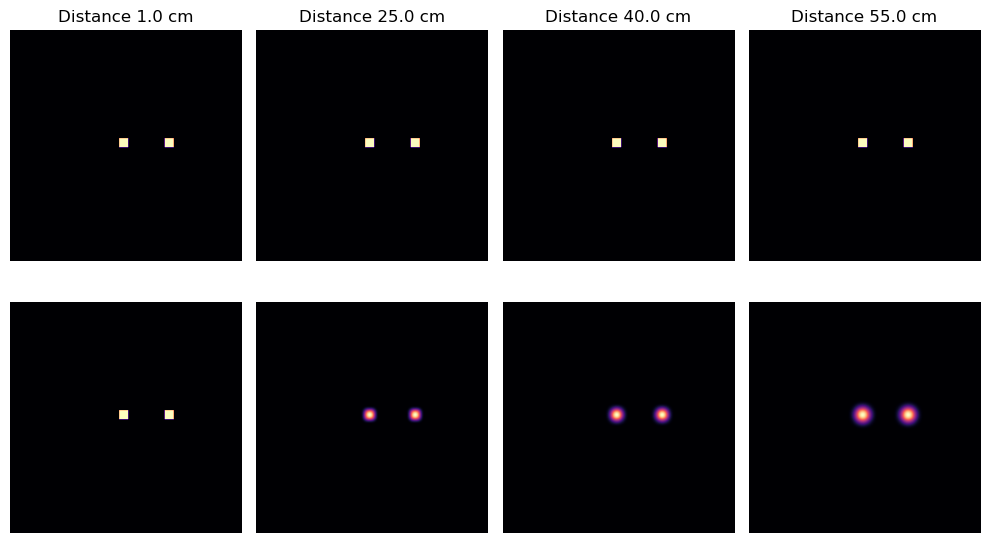

In [8]:
fig, ax = plt.subplots(2,4,figsize=(10,6))
for i in range(4):
    ax[0,i].imshow(input[i].cpu().detach().numpy(), cmap='magma')
    ax[1,i].imshow(ngon_output[i].cpu().detach().numpy(), cmap='magma')
    ax[0,i].set_title(f"Distance {distances[i]} cm")
[a.axis('off') for a in ax.ravel()]
fig.tight_layout()

# Chaining Operators

It is possible to chain operators in `spectpsftoolbox`. For example, in SPECT acquisition, the component above models the PSF component from the collimator structure only, but there is also an PSF component resulting from uncertainty in position when detected in the scintillator. The PSF is best modeled as

$$PSF_{tot}[x] = PSF_{scint}[PSF_{coll}[x]] $$

$PSF_{scint}$ is best modeled using a Gaussian function with width equal to the intrinsic resolution of the scintillator crystal. We can define the operator as:

In [9]:
intrinsic_sigma = 0.1614 # typical for NaI 140keV detection
gauss_amplitude_fn = lambda a, bs: torch.ones_like(a)
gauss_sigma_fn = lambda a, bs: bs[0]*torch.ones_like(a)
gauss_amplitude_params = torch.tensor([1.], requires_grad=True, dtype=torch.float32, device=device)
gauss_sigma_params = torch.tensor([intrinsic_sigma], requires_grad=True, device=device, dtype=torch.float32)
scint_operator = GaussianOperator(
    gauss_amplitude_fn,
    gauss_sigma_fn,
    gauss_amplitude_params,
    gauss_sigma_params,
)

/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


We could use this operator directly on the input:

In [10]:
output_tot = scint_operator(ngon_output, xv_k, yv_k, distances, normalize=True)

OR we can chain together the operators to get a single operator. We can use the `*` operator to make an operator that first applies the operator on the right, then the operator on the left:

In [11]:
spect_psf_operator = scint_operator * ngon_operator
# Now apply directly to inpuy
output_tot = spect_psf_operator(input, xv_k, yv_k, distances, normalize=True)

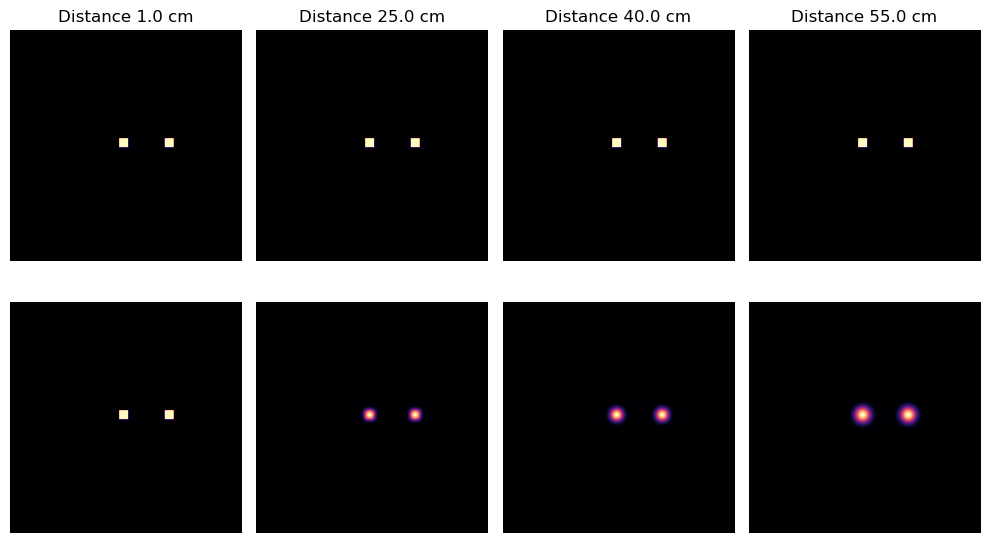

In [12]:
fig, ax = plt.subplots(2,4,figsize=(10,6))
for i in range(4):
    ax[0,i].imshow(input[i].cpu().detach().numpy(), cmap='magma')
    ax[1,i].imshow(output_tot[i].cpu().detach().numpy(), cmap='magma')
    ax[0,i].set_title(f"Distance {distances[i]} cm")
[a.axis('off') for a in ax.ravel()]
fig.tight_layout()

In general, we can combine operators together in complicated ways

In [13]:
combined_operator = (ngon_operator + scint_operator) * ngon_operator + scint_operator

output_weird= spect_psf_operator(input, xv_k, yv_k, distances, normalize=True)

Let's check normalization. Since there were 2 squares each with $10 \times 10 $ pixels of magnitude 1, the blurred image should sum to 200 at each plane:

In [14]:
output_weird.sum(dim=(1,2))

tensor([200.0000, 200.0001, 200.0000, 200.0000], device='cuda:0',
       grad_fn=<SumBackward1>)

* Normalization is carefully tracked for combined operators